<a href="https://colab.research.google.com/github/RocioLiu/Steel-Defect-Detection/blob/master/Kaggle_SteelDefect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle competition - Severstal: Steel Defect Detection
[Severstal: Steel Defect Detection](https://www.kaggle.com/c/severstal-steel-defect-detection/overview)

Reference:  
[RLE functions - Run Lenght Encode & Decode](https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode)  
[RLE to mask converter](https://www.kaggle.com/robertkag/rle-to-mask-converter)

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras

In [3]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


#### Load the dataset from Kaggle

In [0]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import pathlib

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2

In [0]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [0]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [9]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [10]:
!ls

kaggle.json  sample_data


In [0]:
!mkdir ~/.kaggle

In [0]:
# copy "kaggle.json" from "/content/kaggle.json" to "~/.kaggle/kaggle.json"
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [0]:
# Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /root/.kaggle/kaggle.json'
!chmod 600 /root/.kaggle/kaggle.json

In [14]:
# Install Kaggle library
!pip install -q kaggle

     |████████████████████████████████| 122kB 2.8MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


Since there's a warning when run the below code block: "Warning: Looks like you're using an outdated API Version, please consider updating (server 1.5.6 / client 1.5.4) so we should run these code refer to The API is now working for downloads! first:

In [15]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
#Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 2.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=a911c67812dfa8ab5c84a40dad566c86458550b5bc2a89728d60bfe08b375d12
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6


In [0]:
# Set environment variables for using the Kaggle API.
#os.environ["KAGGLE_USERNAME"] = 
#os.environ["KAGGLE_KEY"] = 

* Get the data

In [1]:
!kaggle competitions download -c severstal-steel-defect-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


* Unzip train and test datasets

In [0]:
from zipfile import ZipFile

In [0]:
# This will extract all the files in stage1_test to current directory(/content)
with ZipFile("severstal-steel-defect-detection.zip", 'r') as zipObj:
# Extract all the contents of zip file in a folder "input"
    zipObj.extractall('/content/input')

#### read all text data

In [0]:
train_df = pd.read_csv("input/train.csv")
sample_df = pd.read_csv("input/sample_submission.csv")

In [21]:
train_df.shape

(7095, 3)

In [22]:
train_df.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


In [23]:
sample_df.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


First, check the number of each class

In [24]:
train_df.ClassId.value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

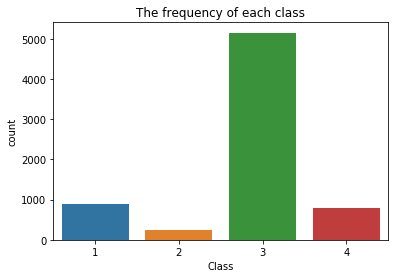

In [25]:
fig, ax = plt.subplots()
ax = sns.countplot(x="ClassId", data=train_df) # sns.countplot(train_df.ClassId)
ax.set_title('The frequency of each class')
ax.set_xlabel('Class');

In [26]:
print("The number of submission sample: ",len(sample_df))

The number of submission sample:  5506


In [27]:
!pwd

/content


In [0]:
train_images_dir = '/content/input/train_images'
test_images_dir = '/content/input/test_images'

In [0]:
train_images_names = sorted([i for i in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, i))])
test_images_names = sorted([i for i in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, i))])

In [30]:
print("Total number of training images: ", len(os.listdir(train_images_dir)))
print("Total number of test images: ", len(os.listdir(test_images_dir)))

Total number of training images:  12568
Total number of test images:  5506


In [0]:
train_images = [os.path.join(train_images_dir, fname) for fname in train_images_names]
test_images = [os.path.join(test_images_dir, fname) for fname in test_images_names]

In [32]:
# Part of the steels are classified more the one type of defect
train_df.ImageId.value_counts()

db4867ee8.jpg    3
ef24da2ba.jpg    3
7fe5d431f.jpg    2
8a642f9d3.jpg    2
4edc8b817.jpg    2
                ..
c9358e43f.jpg    1
7c847f7b3.jpg    1
91222b4c9.jpg    1
0ca915b9f.jpg    1
cf8e21964.jpg    1
Name: ImageId, Length: 6666, dtype: int64

The names in train_images_names but not in train_df are the images that are not defect

In [0]:
#cols = [col for col in df.columns if col not in ['B', 'D']]
#df[df.columns[~df.columns.isin(['C','D'])]]
# sum(train_df.ImageId.isin(train_images_names))

In [0]:
# Extract the non defect images
defect_names = [x for x in train_images_names if x in train_df.ImageId.tolist()]
non_defect_names = [x for x in train_images_names if x not in train_df.ImageId.tolist()]

In [35]:
print("The number of non defect images: ", len(non_defect_names))
print("The number of defect images: ", len(defect_names))

The number of non defect images:  5902
The number of defect images:  6666


In [36]:
len(list(set(defect_names)))

6666

In [0]:
# Split the train images into defect and non-defect
defect_images = [os.path.join(train_images_dir, fname) for fname in defect_names]
non_defect_images = [os.path.join(train_images_dir, fname) for fname in non_defect_names]

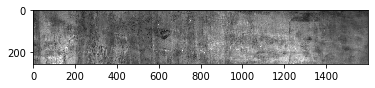

In [38]:
img = mpimg.imread(non_defect_images[50])
plt.imshow(img)

#### check image data

In [0]:
ROWS = 5
COLUMNS = 2

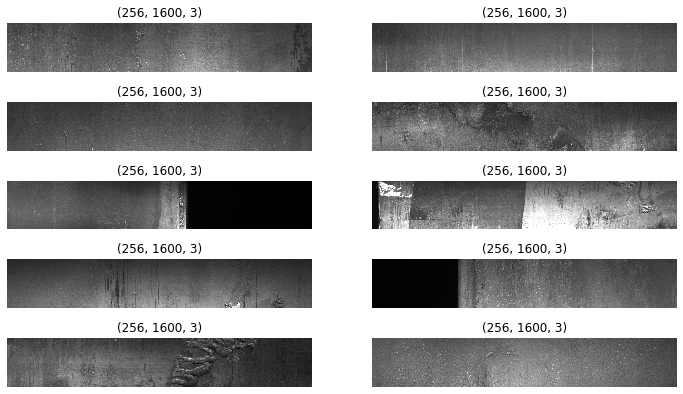

In [30]:
# Check the defect images
fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(12,7))
for i, img_path in enumerate(defect_images[:10]):
  img = mpimg.imread(img_path)
  img_shape = img.shape

  x = i//COLUMNS
  y = i%COLUMNS
  axes[x, y].imshow(img)
  axes[x, y].axis('off')
  axes[x, y].set_title(img.shape)

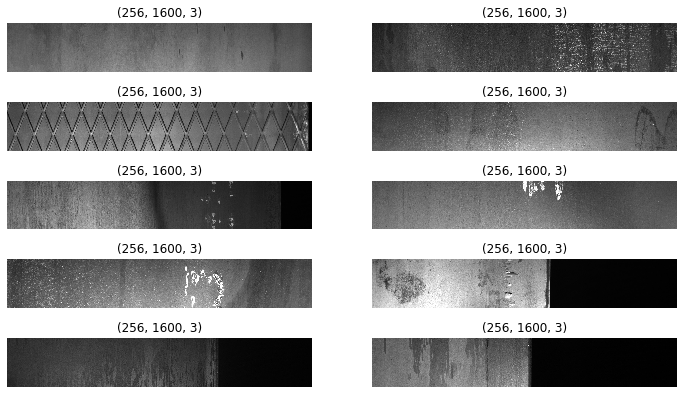

In [31]:
# Check the non-defect images
fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(12,7))
for i, img_path in enumerate(non_defect_images[:10]):
  img = mpimg.imread(img_path)
  img_shape = img.shape

  x = i//COLUMNS
  y = i%COLUMNS
  axes[x, y].imshow(img)
  axes[x, y].axis('off')
  axes[x, y].set_title(img.shape)

In [0]:
# check the size of all training images
train_size_dict = defaultdict(int)
for i in train_images:
  train_shape = mpimg.imread(i).shape
  train_size_dict[train_shape] += 1

In [33]:
train_size_dict

defaultdict(int, {(256, 1600, 3): 12568})

In [0]:
# check the size of all test images
test_size_dict = defaultdict(int)
for i in test_images:
  test_shape = mpimg.imread(i).shape
  test_size_dict[test_shape] += 1

In [35]:
test_size_dict

defaultdict(int, {(256, 1600, 3): 5506})

#### Visualizs thd masks

In [0]:
palette = [(255, 89, 143), (0, 179, 44), (255, 215, 0), (21,178,211)]

In [0]:
def make_mask(img_name):
  #img_name = train_df.ImageId[idx]
  mask_df = train_df[train_df.ImageId.isin([img_name])]
  defect_classes = mask_df.ClassId.values
  mask = np.zeros((256, 1600, 4), dtype=np.uint8)

  for i in range(4):
    if (i+1) in defect_classes:
      rle = mask_df[mask_df.ClassId == (i+1)].EncodedPixels.iloc[0].split(" ")
      rle_pos = map(int,rle[0::2])
      rle_len = map(int,rle[1::2])

      rle2mask = np.zeros(256*1600, dtype=np.uint8)
      for pos, leng in zip(rle_pos, rle_len):
        rle2mask[pos-1:pos+leng-1] = 1
      mask[:, :, i] = rle2mask.reshape(256, 1600, order='F')
    else:
      mask[:, :, i] = np.zeros((256, 1600))
  
  return defect_classes, mask

In [0]:
def show_mask_image(img_name):
  #defect_classes = train_df[train_df.ImageId.isin([img_name])].ClassId
  defect_classes, mask = make_mask(img_name)
  img = mpimg.imread(os.path.join(train_images_dir, img_name))

  fig, ax = plt.subplots(figsize=(15, 5))
  for i in range(4):
    contours, _ = cv2.findContours(mask[:,:,i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for j in range(len(contours)):
      cv2.polylines(img, contours[j], True, palette[i], 2) #cv2.polylines(影像, 頂點座標, 封閉型, 顏色, 線條寬度)
  ax.set_title(img_name)
  ax.imshow(img)

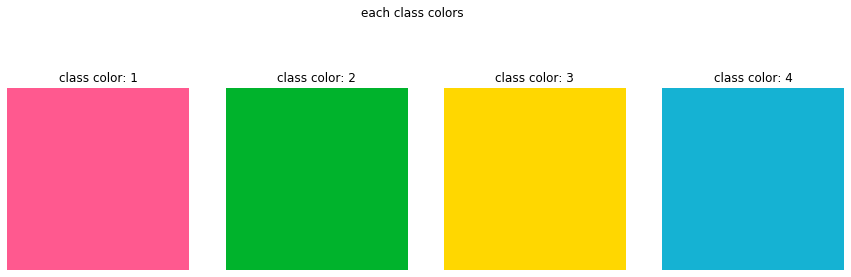

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palette[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

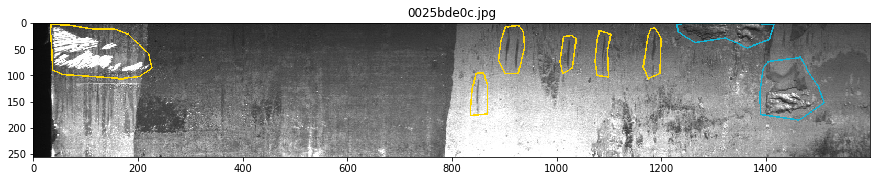

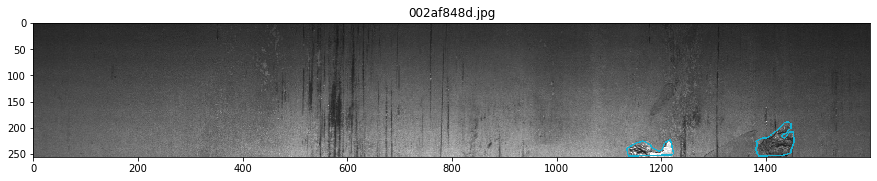

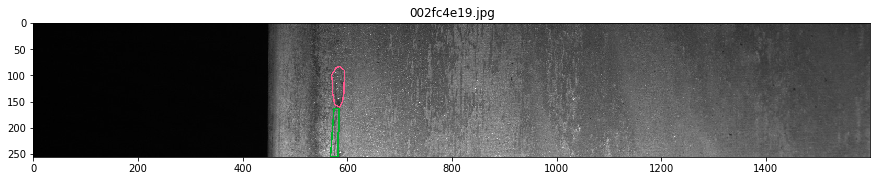

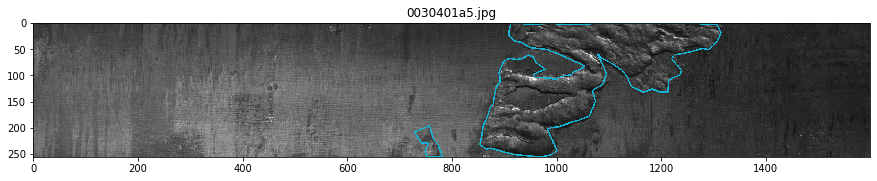

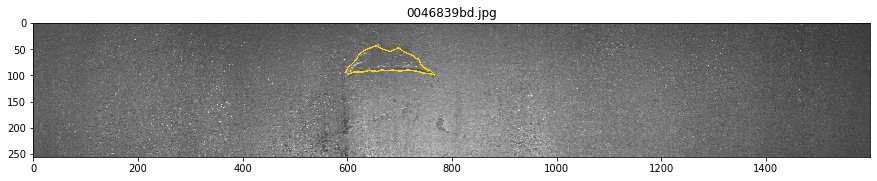

In [43]:
for fname in defect_names[5:10]:
  show_mask_image(fname)

#### Data Generator
To push the data to our model, we will create a custom data generator. A generator lets us load data progressively, instead of loading it all into memory at once. A custom generator allows us to also fit in more customization during the time of loading the data. As the model is being procssed in the GPU, we can use a custom generator to pre-process images via a generator. At this time, we can also take advantage multiple processors to parallelize our pre-processing.

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
  'Generates data for tf'
  def __init__(self, df, list_IDs, batch_size=16, img_h=256, img_w=1600,
               n_classes=4, train_path=train_images_dir, shuffle=True):
    'Initialization'
    self.df = df
    self.list_IDs = list_IDs
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.n_classes = n_classes
    self.train_path = train_path
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    
    # Find list of IDs
    list_IDs_img = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_img)

    return X, y


  def on_epoch_end(self):
     'Updates indexes after each epoch'
     self.indexes = np.arange(len(self.list_IDs))
     if self.shuffle == True:
       np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_img):
     'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
     # Initialization
     X = np.empty((self.batch_size, self.img_h, self.img_w, 3), dtype=np.float32)
     y = np.empty((self.batch_size, self.img_h, self.img_w, self.n_classes), dtype=np.uint8)
     img_names = []

     # Generate data
     for i, img_name in enumerate(list_IDs_img):
       #img_name = self.df.ImageId.iloc[ID]
       img_path = os.path.join(self.train_path, img_name)
       img = cv2.imread(img_path)
       img = img.astype(np.float32) / 255.
       X[i,:,:,:] = img

       #rles = self.df.EncodedPixels.iloc[ID]
       _, masks = make_mask(img_name)
       y[i,:,:,:] = masks

       img_names.append(img_name)

     return X, y

In [0]:
#----------------

In [0]:
train_idx, valid_idx = train_test_split(defect_names, test_size=0.2, random_state=123)

In [0]:
# Parameters
params = {'df': train_df,
          'img_h': 256,
          'img_w':1600,
          'batch_size': 16,
          'n_classes': 4,
          'train_path': '/content/input/train_images',
          'shuffle': True}

In [0]:
#BATCH_SIZE = 32
#train_images_dir = '/content/input/train_images'
train_data_gen = DataGenerator(list_IDs = train_idx, **params)
valid_data_gen = DataGenerator(list_IDs = valid_idx, **params)

#### Build the UNet model
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
def UNet(input_shape):
  x_input = Input(shape=input_shape)

  c1 = Conv2D(8, (3,3), activation='relu', padding='same')(x_input)
  c1 = Conv2D(8, (3,3), activation='relu', padding='same')(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(16, (3,3), activation='relu', padding='same')(p1)
  c2 = Conv2D(16, (3,3), activation='relu', padding='same')(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(32, (3,3), activation='relu', padding='same')(p2)
  c3 = Conv2D(32, (3,3), activation='relu', padding='same')(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(64, (3,3), activation='relu', padding='same')(p3)
  c4 = Conv2D(64, (3,3), activation='relu', padding='same')(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(128, (3,3), activation='relu', padding='same')(p4)
  c5 = Conv2D(128, (3,3), activation='relu', padding='same')(c5)

  u42 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5)
  u42 = concatenate([u42, c4])
  c42 = Conv2D(64, (3,3), activation='relu', padding='same')(u42)
  c42 = Conv2D(64, (3,3), activation='relu', padding='same')(c42)

  u32 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c42)
  u32 = concatenate([u32, c3])
  c32 = Conv2D(32, (3,3), activation='relu', padding='same')(u32)
  c32 = Conv2D(32, (3,3), activation='relu', padding='same')(c32)

  u22 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c32)
  u22 = concatenate([u22, c2])
  c22 = Conv2D(16, (3,3), activation='relu', padding='same')(u22)
  c22 = Conv2D(16, (3,3), activation='relu', padding='same')(c22)

  u12 = Conv2DTranspose(8, (2,2), strides=(2,2), padding='same')(c22)
  u12 = concatenate([u12, c1])
  c12 = Conv2D(8, (3,3), activation='relu', padding='same')(u12)
  c12 = Conv2D(8, (3,3), activation='relu', padding='same')(c12)

  y_output = Conv2D(4, (1,1), activation='sigmoid')(c12)

  model = Model(inputs=[x_input], outputs=[y_output])

  return model

In [0]:
UNet_model = UNet(input_shape=(256, 1600, 3))

In [51]:
UNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 800, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

#### Metrics

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
adam = Adam(lr = 0.05, epsilon = 0.1)

In [0]:
UNet_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[dice_coef])

#### Fit the model

In [0]:
earlystopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint("steelDefect_model.h5", save_best_only=True)

In [55]:
# WARNING:Model.fit_generator (from tensorflow.python.keras.engine.training) is 
# deprecated and will be removed in a future version.
# Instructions for updating:
# Please use Model.fit, which supports generators
# steps_per_epoch=len(train_idx) // BATCH_SIZE,
# callbacks=[earlystopping_cb, checkpoint_cb],
History = UNet_model.fit(train_data_gen,
                         validation_data=valid_data_gen,
                         epochs=30,
                         verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 333 steps, validate for 83 steps
Epoch 1/30
333/333 [==============================] - 358s 1s/step - loss: 0.2161 - dice_coef: 0.0308 - val_loss: 0.0673 - val_dice_coef: 0.0388
Epoch 2/30
333/333 [==============================] - 344s 1s/step - loss: 0.0658 - dice_coef: 0.0391 - val_loss: 0.0660 - val_dice_coef: 0.0366
Epoch 3/30
333/333 [==============================] - 345s 1s/step - loss: 0.0646 - dice_coef: 0.0424 - val_loss: 0.0651 - val_dice_coef: 0.0397
Epoch 4/30
333/333 [==============================] - 345s 1s/step - loss: 0.0639 - dice_coef: 0.0449 - val_loss: 0.0643 - val_dice_coef: 0.0411
Epoch 5/30
333/333 [==============================] - 345s 1s/step - loss: 0.0634 - dice_coef: 0.0459 - val_loss: 0.0656 - val_dice_coef: 0.0564
Epoch 6/30
333/333 [==============================] - 345s 1s/step - loss: 0.0633 - dice_coef: 0.0464 - val_loss: 0.0640 - val_dice_coef: 0.0491
Epoch 7/30
333/333 [=================

In [56]:
History = UNet_model.fit(train_data_gen,
                         validation_data=valid_data_gen,
                         epochs=10,
                         verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 333 steps, validate for 83 steps
Epoch 1/10
333/333 [==============================] - 112s 336ms/step - loss: 0.0356 - dice_coef: 0.3680 - val_loss: 0.0371 - val_dice_coef: 0.3390
Epoch 2/10
333/333 [==============================] - 112s 337ms/step - loss: 0.0351 - dice_coef: 0.3739 - val_loss: 0.0354 - val_dice_coef: 0.3676
Epoch 3/10
333/333 [==============================] - 112s 337ms/step - loss: 0.0346 - dice_coef: 0.3832 - val_loss: 0.0355 - val_dice_coef: 0.3892
Epoch 4/10
333/333 [==============================] - 112s 335ms/step - loss: 0.0347 - dice_coef: 0.3836 - val_loss: 0.0349 - val_dice_coef: 0.3508
Epoch 5/10
333/333 [==============================] - 111s 335ms/step - loss: 0.0342 - dice_coef: 0.3890 - val_loss: 0.0347 - val_dice_coef: 0.3996
Epoch 6/10
333/333 [==============================] - 111s 334ms/step - loss: 0.0341 - dice_coef: 0.3913 - val_loss: 0.0339 - val_dice_coef: 0.3888
Epoch 7/10
333/333 

In [58]:
History = UNet_model.fit(train_data_gen,
                         validation_data=valid_data_gen,
                         epochs=15,
                         verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 333 steps, validate for 83 steps
Epoch 1/15
333/333 [==============================] - 111s 334ms/step - loss: 0.0324 - dice_coef: 0.4153 - val_loss: 0.0329 - val_dice_coef: 0.3951
Epoch 2/15
333/333 [==============================] - 111s 334ms/step - loss: 0.0323 - dice_coef: 0.4199 - val_loss: 0.0327 - val_dice_coef: 0.4095
Epoch 3/15
333/333 [==============================] - 111s 333ms/step - loss: 0.0323 - dice_coef: 0.4181 - val_loss: 0.0323 - val_dice_coef: 0.4310
Epoch 4/15
333/333 [==============================] - 111s 333ms/step - loss: 0.0316 - dice_coef: 0.4283 - val_loss: 0.0317 - val_dice_coef: 0.4467
Epoch 5/15
333/333 [==============================] - 111s 333ms/step - loss: 0.0307 - dice_coef: 0.4436 - val_loss: 0.0314 - val_dice_coef: 0.4329
Epoch 6/15
333/333 [==============================] - 111s 334ms/step - loss: 0.0307 - dice_coef: 0.4438 - val_loss: 0.0310 - val_dice_coef: 0.4206
Epoch 7/15
333/333 

#### Save the model

In [0]:
UNet_model.save("steelDefect_model2.h5")

Save the model onto google drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
UNet_model.save('steelDefect_model2.h5')
model_file = drive.CreateFile({'title' : 'steelDefect_model2.h5'})
model_file.SetContentFile('steelDefect_model2.h5')
model_file.Upload()

In [76]:
# download to google drive  'steelDefect_model.h5'
drive.CreateFile({'id': model_file.get('id')})
# GoogleDriveFile({'id': '1CeWTSuuo6Xihg3jZUBJ0BTeAZb1S6H3I'})

GoogleDriveFile({'id': '1CeWTSuuo6Xihg3jZUBJ0BTeAZb1S6H3I'})

In [65]:
# download to google drive  'steelDefect_model2.h5'
drive.CreateFile({'id': model_file.get('id')})
# GoogleDriveFile({'id': '1HvVwneBKrhBNme4IYvC6vc3d0LUfGmKl'})

GoogleDriveFile({'id': '1HvVwneBKrhBNme4IYvC6vc3d0LUfGmKl'})

Check if it is uploaded from colab

In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Save the model locally

In [0]:
from google.colab import files
files.download('steelDefect_model.h5')

#### Evaluation

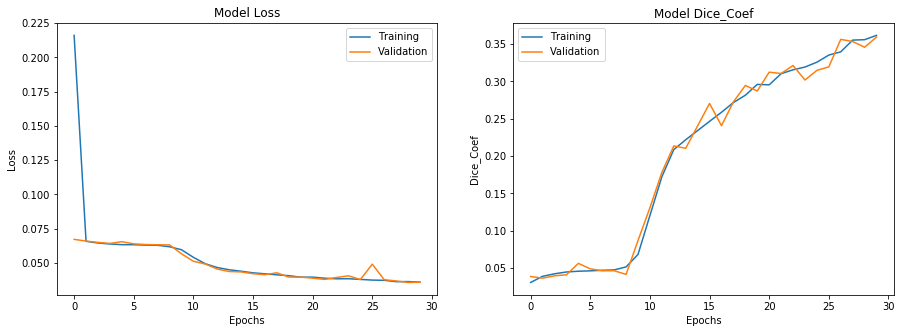

In [77]:
# Plot the Loss and the metirc: dice_coef
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(History.history['loss'])
axes[0].plot(History.history['val_loss'])
axes[0].set_title("Model Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(['Training', 'Validation'], loc="upper right")

axes[1].plot(History.history['dice_coef'])
axes[1].plot(History.history['val_dice_coef'])
axes[1].set_title("Model Dice_Coef")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice_Coef")
axes[1].legend(['Training', 'Validation'], loc="upper left");

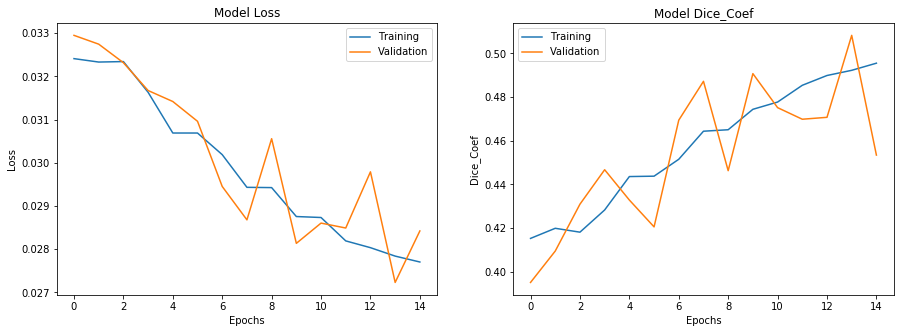

In [59]:
# Plot the Loss and the metirc: dice_coef
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(History.history['loss'])
axes[0].plot(History.history['val_loss'])
axes[0].set_title("Model Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(['Training', 'Validation'], loc="upper right")

axes[1].plot(History.history['dice_coef'])
axes[1].plot(History.history['val_dice_coef'])
axes[1].set_title("Model Dice_Coef")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice_Coef")
axes[1].legend(['Training', 'Validation'], loc="upper left");

#### Load the saved model

In [0]:
UNet_model = load_model("steelDefect_model.h5",
                   custom_objects={"dice_coef":dice_coef})

Loading models from Google Drive into Colab

In [0]:
file_obj = drive.CreateFile({'id': '1CeWTSuuo6Xihg3jZUBJ0BTeAZb1S6H3I'})
file_obj.GetContentFile('steelDefect_model.h5')

In [0]:
file_obj = drive.CreateFile({'id': '1HvVwneBKrhBNme4IYvC6vc3d0LUfGmKl'})
file_obj.GetContentFile('steelDefect_model2.h5')

In [0]:
UNet_model = load_model("steelDefect_model2.h5",
                        custom_objects={"dice_coef":dice_coef})

#### Predict masks on the validation data

In [45]:
preds = UNet_model.predict(valid_data_gen, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
83/83 [==============================] - 35s 423ms/step


In [46]:
preds.shape

(1328, 256, 1600, 4)

In [0]:
def show_mask_image(img_name):
  #defect_classes = train_df[train_df.ImageId.isin([img_name])].ClassId
  defect_classes, mask = make_mask(img_name)
  img = mpimg.imread(os.path.join(train_images_dir, img_name))

  fig, ax = plt.subplots(figsize=(15, 5))
  for i in range(4):
    contours, _ = cv2.findContours(mask[:,:,i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for j in range(len(contours)):
      cv2.polylines(img, contours[j], True, palette[i], 2) #cv2.polylines(影像, 頂點座標, 封閉型, 顏色, 線條寬度)
  ax.set_title(img_name)
  ax.imshow(img)

In [0]:
contours, _ = cv2.findContours(y[0][:,:,2], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

In [211]:
np.sum(y[0,:,:0])

0

In [191]:
contours[0].shape

(3296, 1, 2)

In [198]:
ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palette[i])

(255, 89, 143)

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
X, y = valid_data_gen.__getitem__(1)

In [0]:
import copy

In [0]:
X2 = copy.deepcopy(X)

In [56]:
preds = UNet_model.predict(X, verbose=1)
preds.shape

16/16 [==============================] - 7s 436ms/sample


(16, 256, 1600, 4)

In [0]:
ret, pred_binary = cv2.threshold(preds[0][:,:,j],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [0]:
pred0 = preds[0][:,:,0]

In [73]:
%time
plt.figure(figsize=(20,35))
for i in range(16):
  
  truthClass = []
  predictedClass = []
  

  for j in range(4):
    contours_y, _ = cv2.findContours(y[i,:,:,j], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #ret, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    ret, pred_binary = cv2.threshold(preds[i,:,:,j],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours_pred, _ = cv2.findContours(pred_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if np.sum(y[i,:,:,j]) > 0:
      truthClass.append(j+1)
    if np.sum(pred_binary) > 0:
      predictedClass.append(j+1)
    for k in range(len(contours_y)):
      cv2.polylines(X[i], contours_y[k], True, palette[j], 2)

    for k in range(len(contours_pred)):
      cv2.polylines(X[i], contours_pred[k], True, palette[j], 2)
  plt.subplot(16, 2, i*2+1)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.title('has defect: ' + str(truthClass))

  plt.subplot(16, 2, i*2+2)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.title('Predicted class: ' + str(predictedClass))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


error: ignored

<Figure size 1440x2520 with 0 Axes>

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


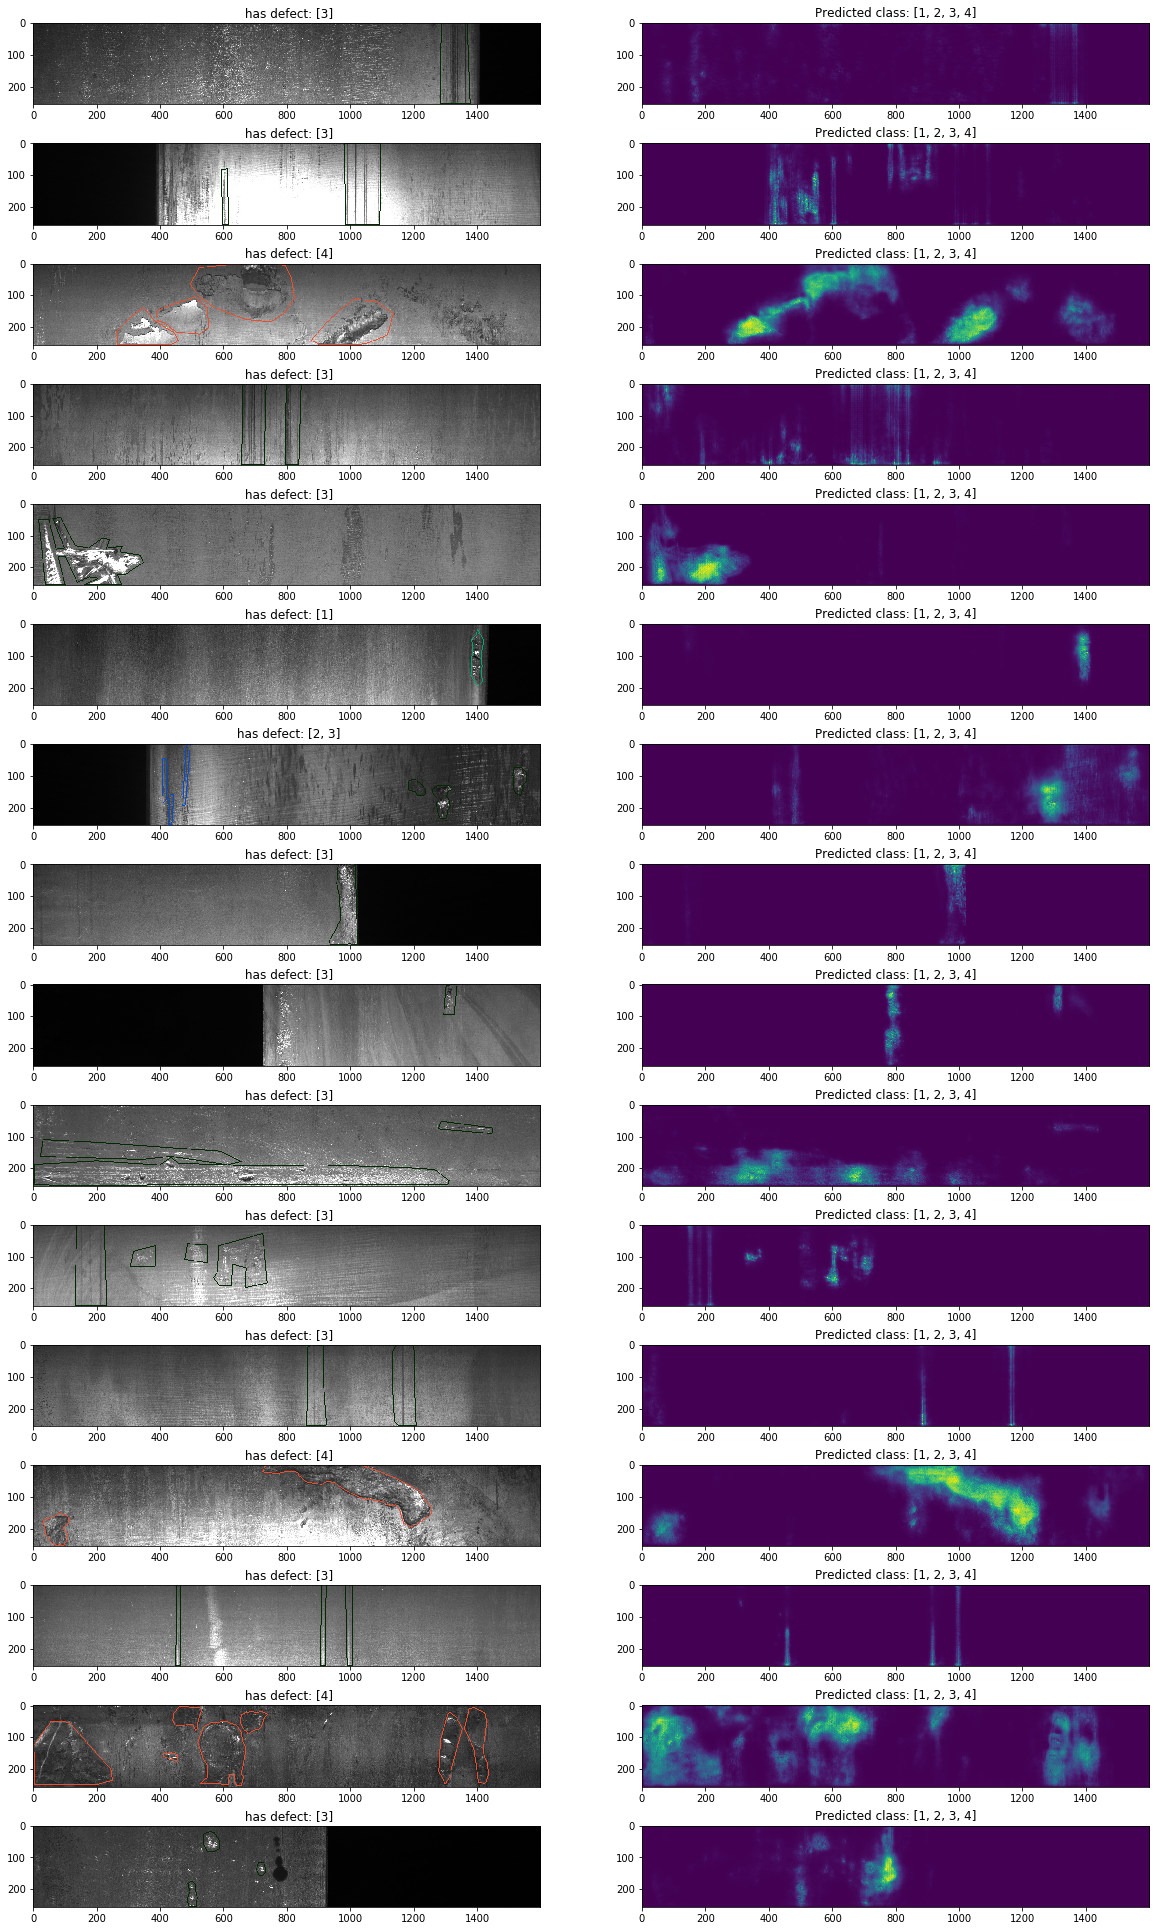

In [57]:
%time
plt.figure(figsize=(20,35))
for i in range(16):
  
  truthClass = []
  predictedClass = []

  for j in range(4):
    contours, _ = cv2.findContours(y[i,:,:,j], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if np.sum(y[i,:,:,j]) > 0:
      truthClass.append(j+1)
    if np.sum(preds[i,:,:,j]) > 0:
      predictedClass.append(j+1)
    for k in range(len(contours)):
      cv2.polylines(X[i], contours[k], True, palette[j], 2)
  plt.subplot(16, 2, i*2+1)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.title(' has defect: ' + str(truthClass))

  plt.subplot(16, 2, i*2+2)
  #plt.imshow(preds[i])
  if np.sum(preds[i,:,:,j]) > 0:
    msk = preds[i,:,:,j]
    plt.imshow(msk)
  else:
    plt.imshow(np.zeros((256,1600)))
  plt.title('Predicted class: ' + str(predictedClass))

In [92]:
np.where(y[0] != 0)

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([71, 72, 73, ..., 84, 85, 86]),
 array([2, 2, 2, ..., 2, 2, 2]))

In [0]:
preds[np.where(preds[0] !=0 ),...]

In [0]:
img_names

In [153]:
np.where(y[10]==1)

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([ 494,  495,  496, ..., 1118, 1119, 1120]),
 array([2, 2, 2, ..., 2, 2, 2]))

In [0]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
defect_classes, mask = make_mask(img_name)
for i in range(4):
  contours, _ = cv2.findContours(y[0][:,:,i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  for j in range(len(contours)):
    cv2.polylines(X[0], contours[j], True, palette[i], 2)
axes.imshow(X[0])

TypeError: ignored

In [117]:
valid_data_gen.__getitem__(0).list_IDs

AttributeError: ignored

In [1]:
!/opt/bin/nvidia-smi

Thu Feb 13 09:54:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
\

In [0]:
class A:
  def __init__(self,li):
    self.li = li
    self.idx =0

  def __getitem__(self,key):
    return self.li[key]
  
  def __len__(self):
    return len(self.li)

  def leng(self):
    return len(self.li)

  def __iter__(self):
    self.a = 0
    return self

  def __next__(self):
    x = self.a
    self.a += 1
    return self.li[x]

In [0]:
a = A([1,2,3,4,5])


In [0]:
def make_mask(img_name):
  #img_name = train_df.ImageId[idx]
  defect_classes = train_df[train_df.ImageId.isin([img_name])].ClassId
  mask = np.zeros((256, 1600, len(defect_classes)), dtype=np.uint8)

  for i in range(len(defect_classes)):
    label = train_df[train_df.ImageId.isin([img_name])].iloc[i].EncodedPixels.split(" ")
    label_pos = map(int, label[0::2])
    label_len = map(int, label[1::2])

    mask_label = np.zeros(256*1600, dtype=np.uint8)
    for pos, leng in zip(label_pos, label_len):
      mask_label[pos-1:pos+leng-1] = 1
    mask[:, :, i] = mask_label.reshape(256, 1600, order='F')
  
  return defect_classes, mask

In [0]:
def show_mask_image(img_name):
  #defect_classes = train_df[train_df.ImageId.isin([img_name])].ClassId
  defect_classes, mask = make_mask(img_name)
  img = mpimg.imread(os.path.join(train_images_dir, img_name))

  fig, ax = plt.subplots(figsize=(15, 5))
  for i in range(len(defect_classes)):
    contours, _ = cv2.findContours(mask[:,:,i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for j in range(len(contours)):
      cv2.polylines(img, contours[j], True, palette[defect_classes.iloc[i]-1], 2) #cv2.polylines(影像, 頂點座標, 封閉型, 顏色, 線條寬度)
  ax.set_title(img_name)
  ax.imshow(img)